In [1]:
import os
import pandas as pd
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy.stats import false_discovery_control

In [2]:
nas_dir = "/home/jaejoong/cocoanlab02"
dat_dir = os.path.join(nas_dir, "projects/AIDA/dataset")
result_dir = os.path.join(nas_dir, "projects/AIDA/results")

In [3]:
all_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_df.csv"))
all_resp_df = pd.read_csv(os.path.join(result_dir, "AIDA_all_resp_stochastic_df.csv"))
all_resp_df = all_resp_df.map(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)

In [4]:
prev_mae = {"Test 1": {"Rosenman2024": 3.46,
                       "Agarwal2024": 3.52,
                       "Milintsevich2024": 3.59,
                       "Milintsevich2023": 3.78,
                       "Lau2023": 3.80},
            "Test 2 E-DAIC": {"Sadeghi2024": 3.86,
                              "Ray2019": 4.02,
                              "Sadeghi2023": 4.26}}
Q_desc = ["Q1: Anhedonia", # Diminished interest or pleasure
          "Q2: Depressed mood",
          "Q3: Sleep disturbance", # Insomnia or hypersomnia
          "Q4: Fatigue", # Fatigue or loss of energy
          "Q5: Appetite disturbance", # Poor appetite or overeating
          "Q6: Worthlessness", # Feelings of worthlessness or guilt
          "Q7: Poor concentration", # Diminished ability to think or concentrate
          "Q8: Psychomotor disturbance", # Psychomotor agitation or retardation
          "Q9: Positive sentiment",
          "Q10: Negative sentiment",
          "Q11: Self-focused language",
          "Q12: Present-focused language",
          "Q13: Emotion differentiation",
          "Q14: Mindreading",
          "Q15: Catastrophizing",
          "Q16: All-or-nothing thinking",
          "Q17: Emotional reasoning",
          "Q18: Labeling",
          "Q19: Mental filter",
          "Q20: Overgeneralization",
          "Q21: Personalization",
          "Q22: Should statements",
          "Q23: Disqualifying the positive"] # Minimizing or disqualifying the positive

In [5]:
def linreg_scaled(X, Y, wh_tr):

    scaler = StandardScaler()
    scaler.fit_transform(X[wh_tr, :])
    X_scaled = scaler.transform(X)
    
    model = LinearRegression()
    model.fit(X_scaled[wh_tr, :], Y[wh_tr])
    Y_pred = model.predict(X_scaled)

    return scaler, model, Y_pred

def linreg_metrics(Y, Y_pred):
    
    mae = mean_absolute_error(Y, Y_pred)
    rmse = root_mean_squared_error(Y, Y_pred)
    r2 = r2_score(Y, Y_pred)
    metrics = {"mae": mae, "rmse": rmse, "r2": r2}

    return metrics

In [6]:
all_mdl = []

for itidx in range(len(all_resp_df.iloc[0,0])):

    all_mdl.append({"Full": {"Q": range(0,23), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
               "PHQ8": {"Q": range(0,8), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
               "Ling": {"Q": range(8,13), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
               "CDS": {"Q": range(13,23), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
               "NonD": {"Q": range(23,33), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}},
               "Dir": {"Q": range(33,34), "scaler": [], "model": [], "Y_pred": [], "metrics": {"Training": [], "Test 1": [], "Test 2": [], "Test 2 E-DAIC": []}}})
    
    for mdl in all_mdl[itidx]:
        
        X = np.array(all_resp_df.map(lambda x: x[itidx]).iloc[:, all_mdl[itidx][mdl]["Q"]])
        Y = np.array(all_df["Depression_severity"])
        wh_tr = np.array(all_df["split"] == "Training")
        
        all_mdl[itidx][mdl]["scaler"], all_mdl[itidx][mdl]["model"], all_mdl[itidx][mdl]["Y_pred"] = linreg_scaled(X, Y, wh_tr)
        for split in ["Training", "Test 1", "Test 2", "Test 2 E-DAIC"]:
            wh_split = all_df["split_edaic" if split == "Test 2 E-DAIC" else "split"] == split
            all_mdl[itidx][mdl]["metrics"][split] = linreg_metrics(Y[wh_split], all_mdl[itidx][mdl]["Y_pred"][wh_split])

In [7]:
joblib.dump(all_mdl, os.path.join(result_dir, "all_mdl_stochastic.joblib"))

['/home/jaejoong/cocoanlab02/projects/AIDA/results/all_mdl_stochastic.joblib']

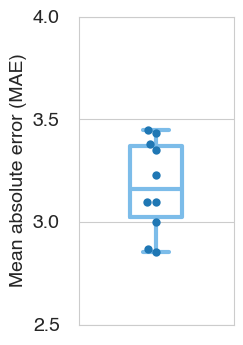

Test 1: MAE = 3.17 ± 0.21 (min = 2.85, max = 3.45)


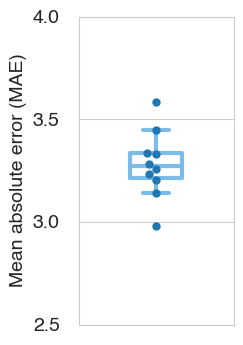

Test 2: MAE = 3.28 ± 0.16 (min = 2.98, max = 3.59)


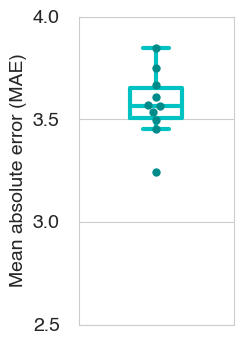

Test 2 E-DAIC: MAE = 3.57 ± 0.16 (min = 3.24, max = 3.85)


In [8]:
for split in ["Test 1", "Test 2", "Test 2 E-DAIC"]:
    y = [all_mdl[itidx]["Full"]["metrics"][split]["mae"] for itidx in range(len(all_mdl))]
    
    plt.figure(figsize=(2, 4))
    sns.set_style("whitegrid", {"font.sans-serif": "Helvetica"})
    sns.boxplot(y, color="#00C2C2" if split == "Test 2 E-DAIC" else "#7CBCE9", showfliers=False, fill=False, linewidth=3, width=0.5)
    sns.swarmplot(y, color="#008B8B" if split == "Test 2 E-DAIC" else "#1F77B4", size=6)
    plt.grid(True, axis='y')
    plt.xlim([-0.75, 0.75])
    plt.ylim([2.5, 4.0])
    plt.xlabel(None)
    plt.ylabel("Mean absolute error (MAE)", fontsize=14)
    plt.yticks(np.arange(2.5, 4.5, 0.5), fontsize=14)
    plt.tick_params(axis='both', length=10)
    plt.gca().get_xaxis().set_visible(False)
    plt.savefig(os.path.join(result_dir, f"AIDA_MAE_stochastic_box_{split.replace(" ", "_")}.pdf"), bbox_inches='tight')
    plt.show()
    print(f"{split}: MAE = {np.mean(y):.2f} ± {np.std(y):.2f} (min = {np.min(y):.2f}, max = {np.max(y):.2f})")